In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import os
import yaml
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm
import torch
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

# Paths
train_image_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"  # Original train set
test_image_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"     # Original val set as test
train_label_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train"
test_label_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Class names for IP102 dataset (102 classes)
class_names = [
    "rice leaf roller", "asiatic rice borer", "yellow rice borer", "rice leaf caterpillar", "rice stem borer", 
    "bronze orange bug", "corn borer", "fall army worm", "armyworm", "beet army worm", "rice water weevil", 
    "red spider mite", "pink hibiscus mealybug", "citrus mealybug", "rice leafhopper", "white backed plant hopper", 
    "small brown plant hopper", "brown plant hopper", "leafhopper", "grain spreader thrips", "rice shell pest", 
    "aphids", "citrus psylla", "citrus spiny whitefly", "citrus leaf miner", "green bug", "english grain aphid", 
    "bird cherry-oat aphid", "pea aphid", "corn leaf aphid", "wheat blossom midge", "pentaleus major", 
    "longlegged spider mite", "wheat phloeothrips", "grub", "mole cricket", "wireworm", "white margined moth", 
    "black cutworm", "large cutworm", "yellow cutworm", "cotton bollworm", "tobacco budworm", "tomato hornworm", 
    "aphid lion", "ladybird beetle", "ground beetle", "rover ant", "webbing clothes moth", "casemaking clothes moth", 
    "house fly", "oriental latrine fly", "lesser house fly", "stable fly", "face fly", "cluster fly", "blow fly", 
    "flesh fly", "house mosquito", "malaria mosquito", "culex mosquito", "yellow fever mosquito", "tobacco moth", 
    "almond moth", "raisin moth", "american cockroach", "australian cockroach", "oriental cockroach", 
    "german cockroach", "brown-banded cockroach", "field cockroach", "smoky brown cockroach", "pavement ant", 
    "argentine ant", "pharaoh ant", "thief ant", "carpenter ant", "red imported fire ant", "black widow", 
    "brown recluse", "hobo spider", "yellow sac spider", "wolf spider", "orb weaver spider", "jumping spider", 
    "cobweb spider", "cellar spider", "crab spider", "vinegaroon", "scorpion", "tick", "mite", "bed bug", 
    "head louse", "body louse", "dog flea", "cat flea", "human flea", "rice leaf beetle", "colorado potato beetle", 
    "bean leaf beetle", "flea beetle", "cucumber beetle", "red flour beetle", "sawtoothed grain beetle", 
    "merchant grain beetle", "larder beetle", "drugstore beetle", "cigarette beetle", "confused flour beetle"
]

In [4]:
# Count files
train_images = [f for f in os.listdir(train_image_dir) if f.endswith('.jpg')]
test_images = [f for f in os.listdir(test_image_dir) if f.endswith('.jpg')]
train_labels = [f.replace('.jpg', '.txt') for f in train_images if os.path.exists(os.path.join(train_label_dir, f.replace('.jpg', '.txt')))]
test_labels = [f.replace('.jpg', '.txt') for f in test_images if os.path.exists(os.path.join(test_label_dir, f.replace('.jpg', '.txt')))]

print(f"Original Train images: {len(train_images)}, Train labels: {len(train_labels)}")
print(f"Test images: {len(test_images)}, Test labels: {len(test_labels)}")

# Split original train set into new train and val sets (80% train, 20% val)
train_images_split, val_images_split = train_test_split(train_images, test_size=0.2, random_state=42)
train_labels_split = [f.replace('.jpg', '.txt') for f in train_images_split if os.path.exists(os.path.join(train_label_dir, f.replace('.jpg', '.txt')))]
val_labels_split = [f.replace('.jpg', '.txt') for f in val_images_split if os.path.exists(os.path.join(train_label_dir, f.replace('.jpg', '.txt')))]
print(f"New Train images: {len(train_images_split)}, New Val images: {len(val_images_split)}")

Original Train images: 17646, Train labels: 17646
Test images: 1329, Test labels: 1329
New Train images: 14116, New Val images: 3530


In [5]:
# Inspect unique classes in train labels
unique_classes = set()
for label_file in tqdm([os.path.join(train_label_dir, f) for f in os.listdir(train_label_dir) if f.endswith('.txt')], desc="Inspecting train labels"):
    try:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                unique_classes.add(class_id)
    except Exception as e:
        print(f"Error reading {label_file}: {e}")
print(f"Unique classes in train set: {sorted(list(unique_classes))}")
print(f"Number of unique classes: {len(unique_classes)}")

# Inspect unique classes in test labels
unique_classes_test = set()
for label_file in tqdm([os.path.join(test_label_dir, f) for f in os.listdir(test_label_dir) if f.endswith('.txt')], desc="Inspecting test labels"):
    try:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                unique_classes_test.add(class_id)
    except Exception as e:
        print(f"Error reading {label_file}: {e}")
print(f"Unique classes in test set: {sorted(list(unique_classes_test))}")
print(f"Number of unique classes in test set: {len(unique_classes_test)}")

Inspecting train labels: 100%|██████████| 17646/17646 [00:54<00:00, 323.05it/s]


Unique classes in train set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
Number of unique classes: 97


Inspecting test labels: 100%|██████████| 1329/1329 [00:03<00:00, 341.33it/s]

Unique classes in test set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
Number of unique classes in test set: 94


In [6]:
# Check and filter invalid annotations
def check_annotation(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Invalid annotation format in {file_path}")
                    return False
                class_id, x, y, w, h = map(float, parts)
                if not (0 < x <= 1 and 0 < y <= 1 and 0 < w <= 1 and 0 < h <= 1):  # Strict check
                    print(f"Invalid box in {file_path}: {parts}")
                    return False
            return True
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return False

# Filter invalid annotations
valid_train_labels = [lbl for lbl in train_labels_split if check_annotation(os.path.join(train_label_dir, lbl))]
valid_val_labels = [lbl for lbl in val_labels_split if check_annotation(os.path.join(train_label_dir, lbl))]
valid_test_labels = [lbl for lbl in test_labels if check_annotation(os.path.join(test_label_dir, lbl))]
print(f"Valid Train labels after filtering: {len(valid_train_labels)}")
print(f"Valid Val labels after filtering: {len(valid_val_labels)}")
print(f"Valid Test labels after filtering: {len(valid_test_labels)}")

Invalid box in /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train/IP046000898.txt: ['45', '0.05416666666666667', '0.21875', '0.0', '0.0125']
Valid Train labels after filtering: 14116
Valid Val labels after filtering: 3529
Valid Test labels after filtering: 1329


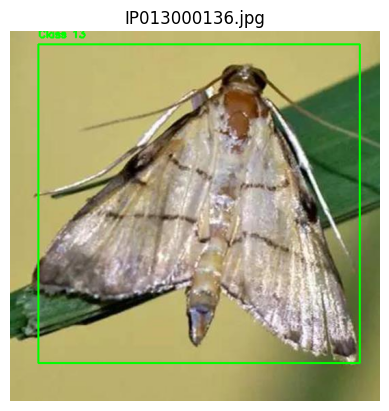

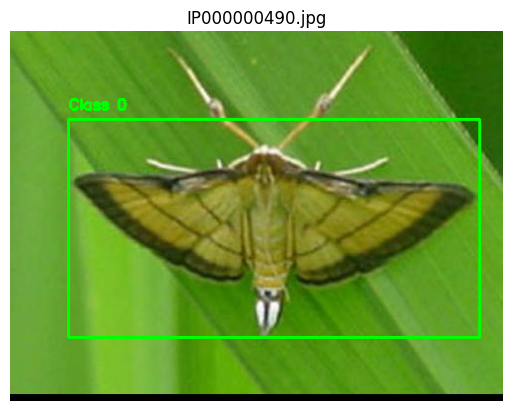

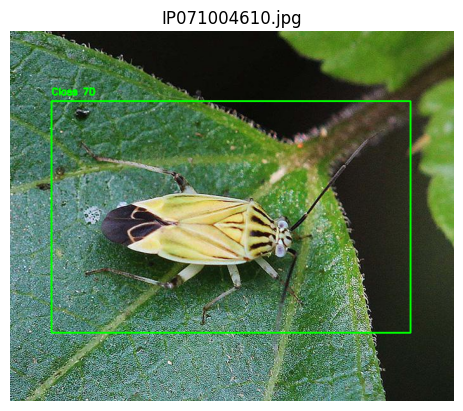

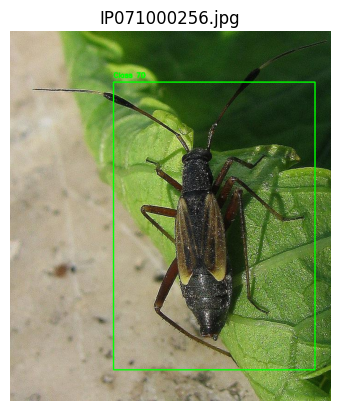

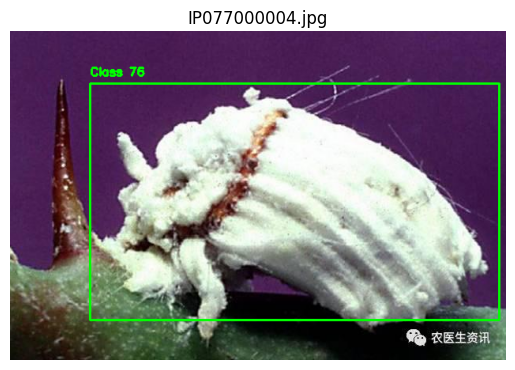

In [7]:
# Plot bounding box for sanity check
def plot_bounding_box(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                h, w, _ = img.shape
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(img, f"Class {int(class_id)}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(image_path))
        plt.show()
    except FileNotFoundError:
        print(f"Label file not found: {label_path}")

# Plot first 5 valid images from new train set
for img_file in train_images_split[:5]:
    label_file = img_file.replace('.jpg', '.txt')
    if label_file in valid_train_labels:
        plot_bounding_box(os.path.join(train_image_dir, img_file), os.path.join(train_label_dir, label_file))

In [8]:
# Load YAML and update paths
with open('/kaggle/input/ip102-yolov5/IP102_YOLOv5/ip102.yaml', 'r') as f:
    data = yaml.safe_load(f)
data['names'] = class_names  # Use the 102-class list
data['nc'] = len(data['names'])  # Set nc to 102
data['train'] = os.path.join(train_image_dir, '')  # Use new train split
data['val'] = os.path.join(train_image_dir, '')   # Use new val split for training validation
data['test'] = os.path.join(test_image_dir, '')   # Add test set path
with open('ip102_updated.yaml', 'w') as f:
    yaml.dump(data, f)


# Initialize model (switch to medium size for better capacity)
model = YOLO('/kaggle/input/yolo11/pytorch/default/1/yolo11s.pt')  # Using YOLOv11 medium model

# Calculate class weights (inverse frequency) for reference (not directly used)
train_label_files = [os.path.join(train_label_dir, f) for f in os.listdir(train_label_dir) if f.endswith('.txt')]
class_counts = np.zeros(len(data['names']))
for label_file in train_label_files:
    with open(label_file, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id < len(data['names']):  # Ensure valid index
                class_counts[class_id] += 1
class_weights = 1.0 / (class_counts + 1e-5)  # Avoid division by zero
class_weights = class_weights / np.sum(class_weights) * len(data['names'])  # Normalize
print("Class weights calculated:", class_weights)  # For debugging

# Train with improved parameters
results = model.train(
    data='ip102_updated.yaml',
    epochs=30,
    imgsz=640,
    batch=32,  # Increased batch size if memory allows
    device=0 if torch.cuda.is_available() else 'cpu',
    project='runs/train',
    name='exp_ip102_improved',
    augment=True,
    auto_augment='randaugment',  # Enhanced augmentation
    lr0=0.001,  # Lower initial learning rate
    lrf=0.01,   # Final learning rate for scheduling
    patience=10,  # Early stopping
    # cls_pw=1.5  # Optional: global class weight (adjust based on experimentation)
)

# Fix for model loading issue: Reload model before periodic AP check
model = YOLO(os.path.join('runs/train/exp_ip102_improved/weights', 'best.pt'))  # Reload best model after training

Class weights calculated: [ 4.7805e-07  6.9357e-07  3.6789e-06  5.0973e-07  1.1134e-06  9.6154e-07  3.2544e-06  7.7629e-07  1.1591e-06  1.6923e-06  5.9588e-07   7.623e-07  4.4534e-06  2.5641e-06  1.3917e-07   1.037e-07  1.6957e-07   1.511e-06  2.8586e-07  5.2232e-07  4.3392e-07  5.3895e-07  2.0688e-07   4.252e-07    6.59e-08  3.8814e-07
  3.5703e-07  2.9483e-07  1.2088e-06  7.1105e-07  3.6789e-06  1.2629e-06  1.4103e-06  8.2956e-07  6.2678e-07  3.3846e-06  2.6442e-06  2.3702e-07  3.3982e-07  2.1641e-07   1.282e-06  9.1973e-07  5.7956e-07  9.5073e-07  1.0073e-06  2.0944e-07  3.8287e-07  2.4814e-07  1.6494e-07  3.3982e-07  1.9057e-07  8.9351e-08
  1.6923e-05  1.4103e-06  1.8803e-06  4.4534e-06  1.5965e-06  2.5641e-06  4.3616e-07      8.4615      8.4615  4.2307e-05  5.1911e-07      8.4615  1.2263e-06  2.9178e-06   3.267e-07  2.6948e-07  5.7956e-07   4.407e-07  7.1769e-08  8.0586e-07  7.0513e-06  8.4615e-07  1.0989e-06      8.4615   3.242e-07  1.6889e-07
  2.4597e-07  4.7805e-07      8.461

100%|██████████| 755k/755k [00:00<00:00, 3.83MB/s]


Overriding model.yaml nc=80 with nc=110

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.8±0.7 ms, read: 6.4±3.9 MB/s, size: 63.4 KB)


train: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:40<00:00, 436.54it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 43.9±28.4 MB/s, size: 29.6 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:17<00:00, 1029.56it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
Plotting labels to runs/train/exp_ip102_improved/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.8e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/exp_ip102_improved
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.94G      1.459      4.236      1.737         38        640: 100%|██████████| 552/552 [05:46<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:05<00:00,  2.20it/s]


                   all      17646      20662      0.499        0.2      0.173      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.98G      1.309      2.282      1.543         40        640: 100%|██████████| 552/552 [05:43<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:02<00:00,  2.25it/s]


                   all      17646      20662      0.522      0.373       0.32       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.98G      1.304      1.905      1.528         35        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662      0.532      0.415      0.374      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.03G      1.286      1.744      1.517         43        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:03<00:00,  2.24it/s]


                   all      17646      20662      0.545      0.473      0.449       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.98G       1.26      1.594      1.494         46        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662      0.583      0.498      0.484      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.98G      1.245      1.492      1.482         38        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:03<00:00,  2.24it/s]


                   all      17646      20662      0.577      0.565      0.553      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.98G      1.233      1.424      1.471         41        640: 100%|██████████| 552/552 [05:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:03<00:00,  2.23it/s]


                   all      17646      20662       0.63      0.566      0.577      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.98G      1.222      1.377      1.462         43        640: 100%|██████████| 552/552 [05:40<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:02<00:00,  2.26it/s]


                   all      17646      20662      0.616      0.597      0.609      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.98G      1.211       1.32       1.45         33        640: 100%|██████████| 552/552 [05:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.28it/s]


                   all      17646      20662      0.632      0.628      0.627      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.98G      1.198      1.278      1.442         33        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662      0.646      0.659      0.661      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.98G      1.189      1.236      1.438         45        640: 100%|██████████| 552/552 [05:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.657      0.666       0.68      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.98G      1.179      1.199      1.426         49        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.666      0.684      0.708       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.12G      1.165      1.176      1.422         40        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.675       0.72      0.736      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.98G      1.151      1.149      1.409         30        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [01:59<00:00,  2.30it/s]


                   all      17646      20662      0.712      0.727      0.761      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      9.13G      1.149      1.123      1.412         36        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662      0.721      0.734      0.768      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.98G      1.141      1.095      1.401         39        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.731      0.764      0.792      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.98G      1.127      1.059      1.392         31        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662       0.75      0.775      0.806      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.98G      1.113      1.038      1.383         45        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.776      0.793      0.829      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      9.02G        1.1       1.01      1.373         52        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [01:59<00:00,  2.30it/s]


                   all      17646      20662      0.793      0.792      0.845      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.98G      1.093     0.9904      1.367         40        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.30it/s]


                   all      17646      20662      0.802       0.79      0.853       0.61
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.98G      1.045     0.7334      1.454         14        640: 100%|██████████| 552/552 [05:39<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.28it/s]


                   all      17646      20662      0.831      0.793      0.869      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.98G      1.019     0.6842      1.431         14        640: 100%|██████████| 552/552 [05:38<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.30it/s]


                   all      17646      20662       0.83      0.825      0.879      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.99G      0.998     0.6571      1.414         15        640: 100%|██████████| 552/552 [05:38<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.847      0.841      0.894       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.99G     0.9806     0.6271      1.403         16        640: 100%|██████████| 552/552 [05:38<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


                   all      17646      20662       0.85      0.845      0.899       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      9.02G     0.9599     0.6052      1.381         39        640: 100%|██████████| 552/552 [05:38<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.30it/s]


                   all      17646      20662      0.861      0.857      0.911      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.99G     0.9454     0.5847      1.367         15        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.883      0.855      0.918      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.98G     0.9273     0.5648      1.357         14        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [01:59<00:00,  2.31it/s]


                   all      17646      20662      0.868      0.876      0.923      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.98G     0.9127     0.5505      1.346         19        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.28it/s]


                   all      17646      20662      0.883      0.875      0.927      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      9.18G      0.896     0.5318      1.331         14        640: 100%|██████████| 552/552 [05:39<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [02:00<00:00,  2.29it/s]


                   all      17646      20662      0.886      0.882      0.931      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.98G     0.8851     0.5191      1.323         14        640: 100%|██████████| 552/552 [05:38<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [01:59<00:00,  2.30it/s]


                   all      17646      20662       0.89      0.881      0.933       0.72

30 epochs completed in 3.860 hours.
Optimizer stripped from runs/train/exp_ip102_improved/weights/last.pt, 19.2MB
Optimizer stripped from runs/train/exp_ip102_improved/weights/best.pt, 19.2MB

Validating runs/train/exp_ip102_improved/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,455,370 parameters, 0 gradients, 21.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 276/276 [03:31<00:00,  1.30it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      17646      20662      0.891      0.875      0.933      0.715
      rice leaf roller        162        177      0.906      0.994      0.988      0.813
    asiatic rice borer        106        122      0.919      0.852      0.956      0.734
     yellow rice borer         23         23      0.943      0.826       0.93      0.687
 rice leaf caterpillar        154        166      0.918      0.886      0.967      0.719
       rice stem borer         75         76      0.874      0.911      0.944      0.691
     bronze orange bug         86         88      0.904      0.989       0.98      0.638
            corn borer         26         26       0.85      0.769      0.908      0.683
        fall army worm        103        109      0.873      0.862      0.949      0.682
              armyworm         73         73      0.776      0.902      0.896      0.606
        beet army worm         48         50      0.815      0.704       0.81      0.607
     rice water weevi

In [9]:
# Periodic AP check after training (every 5 epochs)
for epoch in range(0, 30, 10):  # Updated to match 50 epochs
    print(f"\nEvaluating AP at Epoch {epoch+1}...")
    metrics = model.val()
    print(f"AP: {metrics.box.map:.4f}, AP.50: {metrics.box.map50:.4f}, AP.75: {metrics.box.map75:.4f}")

# Final evaluation on validation set (new val split)
metrics = model.val()
print(f"Final AP on Val: {metrics.box.map:.4f}, AP.50: {metrics.box.map50:.4f}, AP.75: {metrics.box.map75:.4f}")


Evaluating AP at Epoch 1...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,455,370 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 96.3±68.4 MB/s, size: 51.8 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:23<00:00, 765.43it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1103/1103 [02:12<00:00,  8.32it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      17646      20662       0.89      0.885      0.934      0.721
      rice leaf roller        162        177      0.926      0.977      0.987      0.807
    asiatic rice borer        106        122      0.899      0.885      0.956      0.744
     yellow rice borer         23         23          1      0.817      0.926      0.701
 rice leaf caterpillar        154        166      0.918      0.904      0.972      0.731
       rice stem borer         75         76      0.864      0.918      0.941      0.719
     bronze orange bug         86         88      0.925      0.986       0.98       0.64
            corn borer         26         26      0.865      0.808      0.898      0.659
        fall army worm        103        109      0.894      0.852      0.946      0.672
              armyworm         73         73      0.795      0.904      0.876      0.613
        beet army worm         48         50      0.815      0.704      0.817      0.603
     rice water weevi

val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:17<00:00, 1004.57it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1103/1103 [02:12<00:00,  8.35it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      17646      20662       0.89      0.885      0.934      0.721
      rice leaf roller        162        177      0.926      0.977      0.987      0.807
    asiatic rice borer        106        122      0.899      0.885      0.956      0.744
     yellow rice borer         23         23          1      0.817      0.926      0.701
 rice leaf caterpillar        154        166      0.918      0.904      0.972      0.731
       rice stem borer         75         76      0.864      0.918      0.941      0.719
     bronze orange bug         86         88      0.925      0.986       0.98       0.64
            corn borer         26         26      0.865      0.808      0.898      0.659
        fall army worm        103        109      0.894      0.852      0.946      0.672
              armyworm         73         73      0.795      0.904      0.876      0.613
        beet army worm         48         50      0.815      0.704      0.817      0.603
     rice water weevi

val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:15<00:00, 1118.93it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1103/1103 [02:11<00:00,  8.41it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      17646      20662       0.89      0.885      0.934      0.721
      rice leaf roller        162        177      0.926      0.977      0.987      0.807
    asiatic rice borer        106        122      0.899      0.885      0.956      0.744
     yellow rice borer         23         23          1      0.817      0.926      0.701
 rice leaf caterpillar        154        166      0.918      0.904      0.972      0.731
       rice stem borer         75         76      0.864      0.918      0.941      0.719
     bronze orange bug         86         88      0.925      0.986       0.98       0.64
            corn borer         26         26      0.865      0.808      0.898      0.659
        fall army worm        103        109      0.894      0.852      0.946      0.672
              armyworm         73         73      0.795      0.904      0.876      0.613
        beet army worm         48         50      0.815      0.704      0.817      0.603
     rice water weevi

val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:16<00:00, 1064.35it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1103/1103 [02:11<00:00,  8.38it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      17646      20662       0.89      0.885      0.934      0.721
      rice leaf roller        162        177      0.926      0.977      0.987      0.807
    asiatic rice borer        106        122      0.899      0.885      0.956      0.744
     yellow rice borer         23         23          1      0.817      0.926      0.701
 rice leaf caterpillar        154        166      0.918      0.904      0.972      0.731
       rice stem borer         75         76      0.864      0.918      0.941      0.719
     bronze orange bug         86         88      0.925      0.986       0.98       0.64
            corn borer         26         26      0.865      0.808      0.898      0.659
        fall army worm        103        109      0.894      0.852      0.946      0.672
              armyworm         73         73      0.795      0.904      0.876      0.613
        beet army worm         48         50      0.815      0.704      0.817      0.603
     rice water weevi

In [10]:
# Evaluate on test set (original val set)
print("\nEvaluating on Test Set...")
metrics_test = model.val(data='ip102_updated.yaml', split='test')  # Use YAML and specify test split
print(f"Final AP on Test: {metrics_test.box.map:.4f}, AP.50: {metrics_test.box.map50:.4f}, AP.75: {metrics_test.box.map75:.4f}")


Evaluating on Test Set...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7.0±5.7 MB/s, size: 33.8 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:03<00:00, 387.41it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:11<00:00,  7.59it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621      0.516      0.683      0.639       0.41
      rice leaf roller         12         13      0.758      0.923      0.927      0.677
    asiatic rice borer          8          8      0.301        0.5      0.444      0.203
     yellow rice borer          2          2      0.369        0.5      0.373      0.193
 rice leaf caterpillar         12         13      0.457      0.692      0.733      0.477
       rice stem borer          6          6      0.811       0.72      0.786      0.498
     bronze orange bug          7          7      0.731          1      0.943      0.463
            corn borer          2          2      0.361        0.5      0.566      0.258
        fall army worm          8          8      0.471      0.375      0.486        0.3
              armyworm          5          5      0.648          1      0.781       0.52
        beet army worm          4          4      0.544        0.5      0.828      0.394
     rice water weevi

In [ ]:
# Simulate ground truth and predictions for test set
valid_test_images = [img for img in test_images if os.path.exists(os.path.join(test_label_dir, img.replace('.jpg', '.txt')))]
y_true_test = []
y_pred_test = []

for img in tqdm(valid_test_images, desc="Processing test images"):
    label_path = os.path.join(test_label_dir, img.replace('.jpg', '.txt'))
    img_path = os.path.join(test_image_dir, img)
    try:
        # Get ground truth (wrap around invalid indices)
        with open(label_path, 'r') as f:
            y_true_test.append(int(f.readline().split()[0]) % len(data['names']))
        # Get prediction
        results = model.predict(img_path)
        if results and len(results[0].boxes.cls) > 0:
            y_pred_test.append(int(results[0].boxes.cls[0].item()) % len(data['names']))  # Wrap prediction indices
        else:
            y_pred_test.append(-1)  # Placeholder for no detection
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

# Filter out invalid predictions (e.g., -1) and ensure matching lengths
valid_indices_test = [i for i, pred in enumerate(y_pred_test) if pred != -1]
y_true_test_filtered = [y_true_test[i] for i in valid_indices_test]
y_pred_test_filtered = [y_pred_test[i] for i in valid_indices_test]

# Compute additional metrics with error handling for test set
if y_true_test_filtered and y_pred_test_filtered and len(y_true_test_filtered) == len(y_pred_test_filtered):
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_true_test_filtered, y_pred_test_filtered, average='weighted', zero_division=0)
    g_mean_test = np.sqrt(precision_test * recall_test) if (precision_test > 0 and recall_test > 0) else 0
else:
    precision_test, recall_test, f1_test, g_mean_test = 0, 0, 0, 0
    print("Warning: Insufficient or mismatched data for test set classification metrics.")

print("Classification Report for Test Set:")
if y_true_test_filtered and y_pred_test_filtered and len(y_true_test_filtered) == len(y_pred_test_filtered):
    unique_classes_test = sorted(set(y_true_test_filtered))
    target_names_test = [data['names'][i] for i in unique_classes_test if i < len(data['names'])]  # Ensure valid indices
    print(classification_report(y_true_test_filtered, y_pred_test_filtered, labels=unique_classes_test, target_names=target_names_test, zero_division=0))
else:
    print("No valid data for test set classification report.")
print(f"G-mean for Test Set: {g_mean_test:.4f}")

In [ ]:
# Compare with paper (Table 6)
paper_scores = {
    'FRCNN': {'AP': 21.05, 'AP.50': 47.87, 'AP.75': 15.23},
    'FPN': {'AP': 28.10, 'AP.50': 54.93, 'AP.75': 23.30},
    'SSD300': {'AP': 21.49, 'AP.50': 47.21, 'AP.75': 16.57},
    'RefineDet': {'AP': 22.84, 'AP.50': 49.01, 'AP.75': 16.82},
    'YOLOv3': {'AP': 25.67, 'AP.50': 50.64, 'AP.75': 21.79}
}
print("Comparison with Paper Scores on Test Set:")
for model_name, scores in paper_scores.items():
    print(f"{model_name}: AP={scores['AP']:.2f}, AP.50={scores['AP.50']:.2f}, AP.75={scores['AP.75']:.2f}")
    print(f"Improvement: AP={metrics_test.box.map - scores['AP']:.2f}, "
          f"AP.50={metrics_test.box.map50 - scores['AP.50']:.2f}, "
          f"AP.75={metrics_test.box.map75 - scores['AP.75']:.2f}")